In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# Load the dataset
train_df = pd.read_csv("fashion-mnist_train.csv")
test_df = pd.read_csv("fashion-mnist_test.csv")

In [3]:
# Separate features and labels
X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize pixel values (0-1)
y_train = train_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values / 255.0
y_test = test_df.iloc[:, 0].values

In [4]:
# Step 1: Train Baseline Model (Without PCA)
baseline_model = LogisticRegression(max_iter=1000)

start_time = time.time()
baseline_model.fit(X_train, y_train)
baseline_time = time.time() - start_time

baseline_acc = accuracy_score(y_test, baseline_model.predict(X_test))

In [5]:
# Step 2: Apply PCA
pca = PCA(n_components=50)  # Adjust as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [6]:
# Step 3: Train Model on PCA-Reduced Data
pca_model = LogisticRegression(max_iter=1000)

start_time = time.time()
pca_model.fit(X_train_pca, y_train)
pca_time = time.time() - start_time

pca_acc = accuracy_score(y_test, pca_model.predict(X_test_pca))

In [7]:
# Step 4: Compare Results
print(f"Baseline Accuracy: {baseline_acc:.4f}, Time: {baseline_time:.2f}s")
print(f"PCA Accuracy: {pca_acc:.4f}, Time: {pca_time:.2f}s")

Baseline Accuracy: 0.8535, Time: 249.77s
PCA Accuracy: 0.8442, Time: 28.76s


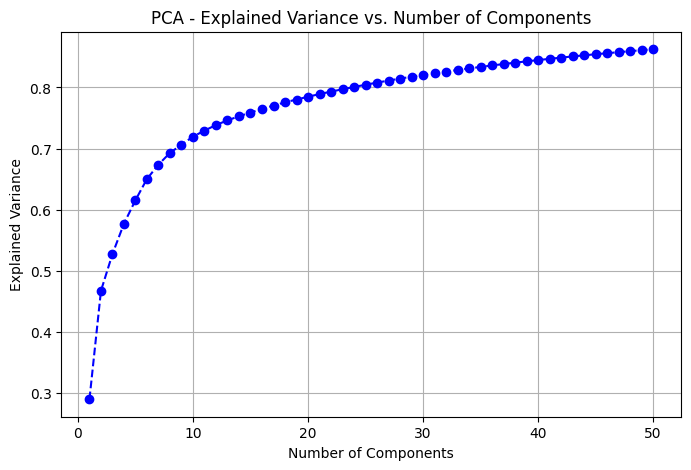

In [8]:
# Step 5: Plot Explained Variance to Choose n_components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid()
plt.show()

In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression

In [26]:
# 📌 Load the dataset
train_df = pd.read_csv("train_m1.csv")
test_df = pd.read_csv("test_m1.csv")

In [27]:
# Display basic info
print(train_df.head(3))

   uid       day  hour  minute    C_motion  feed_water_motion  faucet_hole  \
0    0  Saturday   7.0     NaN  387.374315        2681.205431     0.678352   
1    1  Saturday  12.0    28.0  238.153011        1604.213100     0.679706   
2    2    Friday  15.0    13.0  338.270228        2398.561685     0.662971   

   vapour_pressure  vapour_enthalpy  vapour_pressure_at_division  \
0        25.050893      2775.784134                    26.465138   
1        15.241147      2903.619864                          NaN   
2        23.078376      2796.443584                    24.316160   

   vapour_motion  feed_water_enth  vapour_temperature  \
0    2682.758692      1289.082351          601.850322   
1    1602.318002      1144.454102          603.933579   
2            NaN      1258.098883          602.443281   

   output_electricity_generation  
0                     974.182544  
1                     593.915516  
2                     884.033450  


In [28]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uid                            50400 non-null  int64  
 1   day                            44921 non-null  object 
 2   hour                           44787 non-null  float64
 3   minute                         44930 non-null  float64
 4   C_motion                       44883 non-null  float64
 5   feed_water_motion              44803 non-null  float64
 6   faucet_hole                    44834 non-null  float64
 7   vapour_pressure                44921 non-null  float64
 8   vapour_enthalpy                44963 non-null  float64
 9   vapour_pressure_at_division    44923 non-null  float64
 10  vapour_motion                  44923 non-null  float64
 11  feed_water_enth                44904 non-null  float64
 12  vapour_temperature             44883 non-null 

In [29]:
train_df.isna().sum()
test_df.isna().sum()

uid                               0
day                            2358
hour                           2357
minute                         2382
C_motion                       2394
feed_water_motion              2315
faucet_hole                    2349
vapour_pressure                2452
vapour_enthalpy                2384
vapour_pressure_at_division    2326
vapour_motion                  2415
feed_water_enth                2347
vapour_temperature             2371
dtype: int64

In [30]:
# ============================
# 2️⃣ Drop UID if it exists
# ============================
if 'uid' in train_df.columns:
    train_df.drop(columns=['uid'], inplace=True)
if 'uid' in test_df.columns:
    test_df.drop(columns=['uid'], inplace=True)

# ============================
# 3️⃣ Encode Categorical Variables
# ============================
if 'day' in train_df.columns and train_df['day'].dtype == 'object':
    le = LabelEncoder()
    train_df['day'] = le.fit_transform(train_df['day'].astype(str))
    test_df['day'] = le.transform(test_df['day'].astype(str))

# ============================
# 4️⃣ Handle Missing Values
# ============================
num_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'output_electricity_generation' in num_features:
    num_features.remove('output_electricity_generation')

imputer = SimpleImputer(strategy='median')
train_df[num_features] = imputer.fit_transform(train_df[num_features])
test_df[num_features] = imputer.transform(test_df[num_features])

# ============================
# 5️⃣ Feature Scaling
# ============================
scaler = StandardScaler()
train_df[num_features] = scaler.fit_transform(train_df[num_features])
test_df[num_features] = scaler.transform(test_df[num_features])

# ============================
# 6️⃣ Split Data
# ============================
X = train_df[num_features]
y = train_df['output_electricity_generation']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# ============================
# 7️⃣ Feature Selection
# ============================

# (A) **Filter Method (SelectKBest)**
k_best = SelectKBest(score_func=f_regression, k=10)  # Select top 10 features
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_val_kbest = k_best.transform(X_val)

# (B) **Wrapper Method (Recursive Feature Elimination - RFE)**
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_val_rfe = rfe_selector.transform(X_val)

# (C) **Embedded Method (RandomForest Feature Importance)**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_

# Select top 10 important features
important_features = np.argsort(feature_importances)[-10:]
X_train_rf = X_train.iloc[:, important_features]
X_val_rf = X_val.iloc[:, important_features]

In [32]:
# ============================
# 8️⃣ Train & Evaluate Model
# ============================

def train_and_evaluate(X_train, X_val, y_train, y_val, method_name):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"\n🔹 **Results using {method_name}**")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ MSE: {mse:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

# Evaluate for different feature selection methods
train_and_evaluate(X_train_kbest, X_val_kbest, y_train, y_val, "SelectKBest (Filter Method)")
train_and_evaluate(X_train_rfe, X_val_rfe, y_train, y_val, "RFE (Wrapper Method)")
train_and_evaluate(X_train_rf, X_val_rf, y_train, y_val, "RandomForest Feature Importance (Embedded Method)")


🔹 **Results using SelectKBest (Filter Method)**
✅ MAE: 0.7930
✅ MSE: 8.4036
✅ R² Score: 0.9997

🔹 **Results using RFE (Wrapper Method)**
✅ MAE: 0.7930
✅ MSE: 8.4036
✅ R² Score: 0.9997

🔹 **Results using RandomForest Feature Importance (Embedded Method)**
✅ MAE: 0.7923
✅ MSE: 8.6606
✅ R² Score: 0.9997


In [33]:
# ============================
# 8️⃣ Train & Evaluate Model
# ============================

best_r2 = float('-inf')  # Initialize best R² score
best_method = None  # Track best feature selection method
results = {}

def train_and_evaluate(X_train, X_val, y_train, y_val, method_name):
    global best_r2, best_method
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results[method_name] = r2  # Store R² score

    print(f"\n🔹 **Results using {method_name}**")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ MSE: {mse:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

    # Update best model
    if r2 > best_r2:
        best_r2 = r2
        best_method = method_name

# Evaluate for different feature selection methods
train_and_evaluate(X_train_kbest, X_val_kbest, y_train, y_val, "SelectKBest (Filter Method)")
train_and_evaluate(X_train_rfe, X_val_rfe, y_train, y_val, "RFE (Wrapper Method)")
train_and_evaluate(X_train_rf, X_val_rf, y_train, y_val, "RandomForest Feature Importance (Embedded Method)")

# ============================
# 9️⃣ Print Best Feature Selection Method
# ============================
print("\n🏆 **Best Feature Selection Method:**")
print(f"🔹 {best_method} with R² Score: {best_r2:.4f}")


🔹 **Results using SelectKBest (Filter Method)**
✅ MAE: 0.7930
✅ MSE: 8.4036
✅ R² Score: 0.9997

🔹 **Results using RFE (Wrapper Method)**
✅ MAE: 0.7930
✅ MSE: 8.4036
✅ R² Score: 0.9997

🔹 **Results using RandomForest Feature Importance (Embedded Method)**
✅ MAE: 0.7923
✅ MSE: 8.6606
✅ R² Score: 0.9997

🏆 **Best Feature Selection Method:**
🔹 SelectKBest (Filter Method) with R² Score: 0.9997


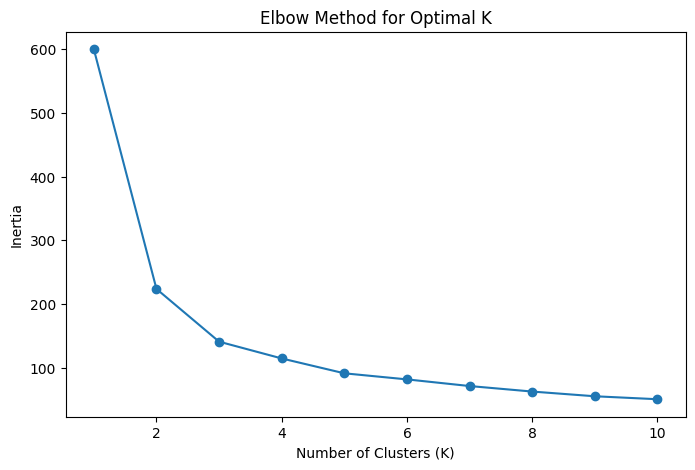

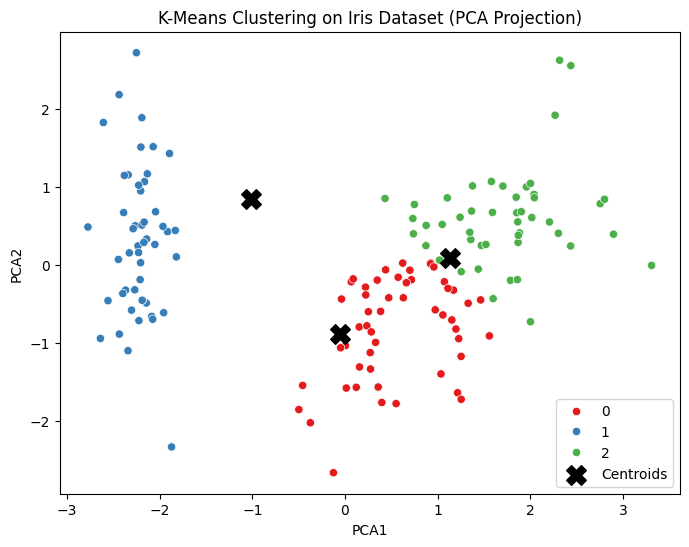


Cluster Counts:
 Cluster
0    53
1    50
2    47
Name: count, dtype: int64


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================
# 1️⃣ Load Dataset
# ============================
iris_url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
iris_df = pd.read_csv(iris_url)

# ============================
# 2️⃣ Preprocessing
# ============================
# Remove target labels (for unsupervised learning)
X = iris_df.drop(columns=['species'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
# 3️⃣ Finding the Optimal K (Elbow Method)
# ============================
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# ============================
# 4️⃣ Apply K-Means with Best K (Assuming 3 from the Elbow Method)
# ============================
optimal_k = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
iris_df['Cluster'] = kmeans.fit_predict(X_scaled)

# ============================
# 5️⃣ Visualizing Clusters (Using PCA for 2D Projection)
# ============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
iris_df['PCA1'] = X_pca[:, 0]
iris_df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=iris_df['Cluster'], palette='Set1', data=iris_df)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label="Centroids")
plt.legend()
plt.title("K-Means Clustering on Iris Dataset (PCA Projection)")
plt.show()

# ============================
# 6️⃣ Print Cluster Counts
# ============================
print("\nCluster Counts:\n", iris_df['Cluster'].value_counts())